<a href="https://colab.research.google.com/github/MuhammadShifa/Anamoly-Detection-Model-ADM-in-Health-Care-Insurance-/blob/main/Healthcare_ADM_with_Keras_Horovod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install horovod[tensorflow,keras,pytorch,mxnet,spark]

#### Load the training dataset

In [ ]:
# import all the necessary packages

import horovod.keras as hvd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras import backend as k
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Load the dataset for training and validation
train_dataset = pd.read_csv('/content/drive/My Drive/ADM Datasets/train_data.csv')
print(train_dataset.shape)

# Print first 10 value of data frame
train_dataset.head(10)



(558211, 27)


,Provider,PotentialFraud,InscClaimAmtReimbursed,DeductibleAmtPaid,AdmitDays,Gender,Race,RenalDiseaseIndicator,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,IsDead
0,PRV51001,0,20,0.0,7.0,1,1,1,12,12,1,1,1,1,2,2,1,1,2,2,2,0,0,300,110,80.0,0.0
1,PRV51001,0,700,0.0,7.0,1,1,0,12,12,1,2,2,2,2,2,1,1,1,2,1,0,0,720,10,67.0,0.0
2,PRV51001,0,900,0.0,7.0,2,1,0,12,12,2,2,1,2,2,2,1,1,2,1,2,0,0,1380,370,76.0,0.0
3,PRV51001,0,500,0.0,7.0,1,1,0,12,12,1,1,1,1,1,1,1,1,2,2,2,2020,1068,6700,2700,74.0,0.0
4,PRV51001,0,36000,1068.0,5.0,1,1,0,12,12,2,1,1,2,2,1,1,1,2,2,1,36000,1068,3520,140,69.0,0.0
5,PRV51001,0,12000,1068.0,3.0,1,1,0,12,12,2,2,1,2,2,2,2,2,2,2,2,95000,2136,2270,900,72.0,0.0
6,PRV51001,0,70,0.0,7.0,1,1,0,12,12,1,1,2,2,2,2,2,1,1,2,2,5000,1068,370,70,91.0,0.0
7,PRV51001,0,100,0.0,7.0,2,2,0,12,12,2,1,1,2,2,2,2,2,1,2,2,0,0,320,80,90.0,0.0
8,PRV51001,0,300,0.0,7.0,2,2,1,12,12,1,1,1,2,1,2,1,1,2,2,2,0,0,630,130,57.0,0.0
9,PRV51001,0,60,0.0,7.0,2,2,1,12,12,2,1,1,2,1,1,1,1,2,2,2,0,0,1590,1070,98.0,0.0


#### Horovod Step 1

In [ ]:
# 1. Horovod: intialize horovod library
hvd.init()

#### Horovod Step 2

In [ ]:
# 2. Horovod: Pin a GPU to each worker
# Horovod: pin GPU to be used to process local rank (one GPU per process), this code because we have tf v2
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
  tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()],'GPU')
print("The gpus is: ",gpus)
print("The local rank is: ", hvd.local_rank())

The gpus is:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
The local rank is:  0


#### Preprocessing and mlp model creation

In [ ]:
# Droping the Duplicate row 
train_dataset = train_dataset.drop_duplicates(subset = None,inplace= False )

#Changing pandas dataframe into input and output numpy array
input = train_dataset.iloc[:,2:28].values.astype('float32')
output = train_dataset.iloc[:,1:2].values.astype('float32')

# Scaled the input with MinMaxScaler
input_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_input = input_scaler.fit_transform(input)

# one hot encoding the output of training dataset
output_encoder = OneHotEncoder()
encoded_output = output_encoder.fit_transform(output).toarray()

print(scaled_input.shape)
print(encoded_output.shape)

input_dim = scaled_input.shape[-1]
print(input_dim)

#Split into train test set
X_train,X_test,y_train,y_test = train_test_split(scaled_input, encoded_output, test_size = 0.25)


# Define Model parameter

batch_size = 32
num_classes = 2

# Horovod: adjust number of epochs based on number of gpu
epochs = int(math.ceil(20.0 / hvd.size())) 
# Neural network
model = Sequential()
model.add(Dense(36, input_dim=input_dim, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))


(534843, 25)
(534843, 2)
25


#### Horovod Step 3

In [ ]:
# 3. Horovod: wrap the optimizer
# Adjust the learning rate based on the number of gpu
opt = keras.optimizers.Adam(0.001 * hvd.size())
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

# Horovod: add Horovod Distributed Optimizer.
opt = hvd.DistributedOptimizer(opt)
print("The hvd distributed optimizer is: ", opt)

The hvd distributed optimizer is:  <horovod._keras.Adam object at 0x7fc348f2bc18>


#### Horovod Step 4

In [ ]:
# 4. Horovod: Synchronize state accross workers

callbacks = [
    # Horovod: broadcast initial variable states from rank 0 to all other processes.
    # This is necessary to ensure consistent initialization of all workers when
    # training is started with random weights or restored from a checkpoint.
    hvd.callbacks.BroadcastGlobalVariablesCallback(0),
]

print("The callbacks is: ", callbacks)

The callbacks is:  [<horovod.keras.callbacks.BroadcastGlobalVariablesCallback object at 0x7fc348fb17f0>]


#### Horovod Step 5

In [ ]:
# 5. Horovod: Checkpoint on the first worker
# Horovod: save checkpoints only on worker 0 to prevent other workers from corrupting them.
if hvd.rank() == 0:
    callbacks.append(keras.callbacks.ModelCheckpoint('./checkpoint-{epoch}.h5'))


#### Model training

In [ ]:
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          callbacks=callbacks,
          epochs=epochs,
          verbose=1 if hvd.rank() == 0 else 0,
          validation_data=(X_test, y_test))
model.save('/content/drive/My Drive/ADM Datasets/mlp_horovod_model.h5')
print('Congrats! Model Saved')

Epoch 1/20
12536/12536 [==============================] - 55s 4ms/step - loss: 0.6642 - accuracy: 0.6257 - val_loss: 0.6562 - val_accuracy: 0.6339
Epoch 2/20
12536/12536 [==============================] - 53s 4ms/step - loss: 0.6560 - accuracy: 0.6339 - val_loss: 0.6572 - val_accuracy: 0.6339
Epoch 3/20
12536/12536 [==============================] - 54s 4ms/step - loss: 0.6567 - accuracy: 0.6320 - val_loss: 0.6563 - val_accuracy: 0.6339
Epoch 4/20
12536/12536 [==============================] - 53s 4ms/step - loss: 0.6556 - accuracy: 0.6345 - val_loss: 0.6562 - val_accuracy: 0.6339
Epoch 5/20
12536/12536 [==============================] - 53s 4ms/step - loss: 0.6565 - accuracy: 0.6325 - val_loss: 0.6560 - val_accuracy: 0.6339
Epoch 6/20
12536/12536 [==============================] - 53s 4ms/step - loss: 0.6556 - accuracy: 0.6343 - val_loss: 0.6559 - val_accuracy: 0.6339
Epoch 7/20
12536/12536 [==============================] - 53s 4ms/step - loss: 0.6558 - accuracy: 0.6336 - val_loss: 0

#### Model Evaluation

In [ ]:
loss_train, acc_train = model.evaluate(X_train, y_train, verbose = 0)
loss_val, acc_val = model.evaluate(X_test, y_test, verbose = 0)
print("The train loss is: {0} and the train accuracy is: {1}".format(loss_train, acc_train))
print("The validation loss is: {0} and the validation accuracy is: {1}".format(loss_val, acc_val))

The train loss is: 0.6545116305351257 and the train accuracy is: 0.6353120803833008
The validation loss is: 0.6561300754547119 and the validation accuracy is: 0.6337997913360596


#### Accuracy, Precision, Recall, F1 Score, roc auc Curve and confusion marix

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)

print(yhat_probs) # 2-D
print(yhat_classes) # 1-D

# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
y_test_1D = output_encoder.inverse_transform(y_test) # Need to be in 1D

print(yhat_probs)
print(yhat_classes)
print()


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_1D, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_1D, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_1D, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_1D, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test_1D, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test_1D, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test_1D, yhat_classes)
print(matrix)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[0.72752726 0.27247274]
 [0.7776309  0.2223691 ]
 [0.7793836  0.22061636]
 ...
 [0.3717535  0.6282465 ]
 [0.76869774 0.2313022 ]
 [0.718872   0.28112802]]
[0 0 0 ... 1 0 0]
[0.72752726 0.7776309  0.7793836  ... 0.3717535  0.76869774 0.718872  ]
[0 0 0 ... 1 0 0]

Accuracy: 0.633800
Precision: 0.570021
Recall: 0.110314
F1 score: 0.184854
Cohens kappa: 0.071519
ROC AUC: 0.455852
[[79194  4188]
 [44777  5552]]


#### Visualization of training loss and accuracy

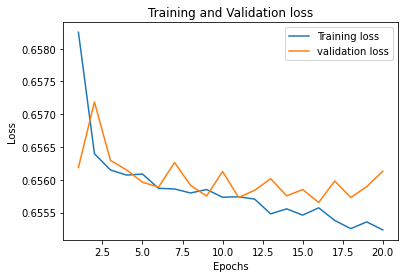

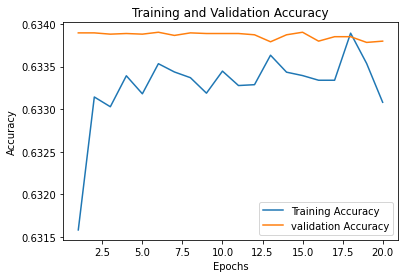

In [ ]:
import matplotlib.pyplot as plt

# plot loss during training
epoch_range = range(1,epochs+1)
plt.plot(epoch_range,history.history['loss'], label='Training loss')
plt.plot(epoch_range,history.history['val_loss'], label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot Accuracy during training
plt.plot(epoch_range,history.history['accuracy'], label='Training Accuracy')
plt.plot(epoch_range,history.history['val_accuracy'], label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Making Prediction on Saved Horovod MLP Model 

#### Load the saved classifier or model

In [ ]:
from keras.models import load_model
#Load the saved Model and do prediction

classifier = load_model('/content/drive/My Drive/ADM Datasets/mlp_horovod_model.h5')

#### Prediction on test dataset

In [ ]:
# Now make prediction on saved Model/classifier for test dataset
# load the dataset for testing the model

pred_dataset = pd.read_csv('/content/drive/My Drive/ADM Datasets/test_data.csv')

#Changing pandas dataframe to numpy array
pred_input = pred_dataset.iloc[:,2:28].values.astype('float32')
pred_output = pred_dataset.iloc[:,1:2].values.astype('float32')

# Scaled the input and output for prediction
pred_input_scaled = input_scaler.fit_transform(pred_input)
pred_output_endcoded = output_encoder.fit_transform(pred_output).toarray()

# evaluate the loss and accuracy for the prediction dataset
pred_loss, pred_acc = classifier.evaluate(pred_input_scaled, pred_output_endcoded, verbose =0)
print("The Predicted dataset loss is: {0} and Accuracy is: {1}".format(pred_loss, pred_acc))



The Predicted dataset loss is: 0.658100426197052 and Accuracy is: 0.6299123167991638


In [ ]:
# Prediction on input data

prediction = classifier.predict(pred_input_scaled)

# Inverse transform the predicted and output encoded value
inv_predict = output_encoder.inverse_transform(prediction).astype('int64')
inv_actual = output_encoder.inverse_transform(pred_output_endcoded).astype('int64')
for j in range(0,len(pred_output)):
        print("Pred={0} Act={1}\n".format(inv_predict[j], inv_actual[j]))

Streaming output truncated to the last 5000 lines.
Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[1] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[1] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[1] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[1] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=[1]

Pred=[0] Act=

## Tying all together, the complete code is listed below [Training Part]

In [ ]:
# import all the necessary packages

import horovod.keras as hvd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras import backend as k
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Load the dataset for training and validation
train_dataset = pd.read_csv('/content/drive/My Drive/ADM Datasets/train_data.csv')
print(train_dataset.shape)

# Print first 10 value of data frame
train_dataset.head(10)
# 1. Horovod: intialize horovod library
hvd.init()
# 2. Horovod: Pin a GPU to each worker
# Horovod: pin GPU to be used to process local rank (one GPU per process), this code because we have tf v2
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
  tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()],'GPU')
print("The gpus is: ",gpus)
print("The local rank is: ", hvd.local_rank())
# Droping the Duplicate row 
train_dataset = train_dataset.drop_duplicates(subset = None,inplace= False )

#Changing pandas dataframe into input and output numpy array
input = train_dataset.iloc[:,2:28].values.astype('float32')
output = train_dataset.iloc[:,1:2].values.astype('float32')

# Scaled the input with MinMaxScaler
input_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_input = input_scaler.fit_transform(input)

# one hot encoding the output of training dataset
output_encoder = OneHotEncoder()
encoded_output = output_encoder.fit_transform(output).toarray()

print(scaled_input.shape)
print(encoded_output.shape)

input_dim = scaled_input.shape[-1]
print(input_dim)

#Split into train test set
X_train,X_test,y_train,y_test = train_test_split(scaled_input, encoded_output, test_size = 0.25)


# Define Model parameter

batch_size = 32
num_classes = 2

# Horovod: adjust number of epochs based on number of gpu
epochs = int(math.ceil(20.0 / hvd.size())) 
# Neural network
model = Sequential()
model.add(Dense(36, input_dim=input_dim, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

# 3. Horovod: wrap the optimizer
# Adjust the learning rate based on the number of gpu
opt = keras.optimizers.Adam(0.001 * hvd.size())
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

# Horovod: add Horovod Distributed Optimizer.
opt = hvd.DistributedOptimizer(opt)


# 4. Horovod: Synchronize state accross workers
callbacks = [
    # Horovod: broadcast initial variable states from rank 0 to all other processes.
    # This is necessary to ensure consistent initialization of all workers when
    # training is started with random weights or restored from a checkpoint.
    hvd.callbacks.BroadcastGlobalVariablesCallback(0),
]

# 5. Horovod: Checkpoint on the first worker
# Horovod: save checkpoints only on worker 0 to prevent other workers from corrupting them.
if hvd.rank() == 0:
    callbacks.append(keras.callbacks.ModelCheckpoint('./checkpoint-{epoch}.h5'))

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          callbacks=callbacks,
          epochs=epochs,
          verbose=1 if hvd.rank() == 0 else 0,
          validation_data=(X_test, y_test))
model.save('/content/drive/My Drive/ADM Datasets/mlp_horovod_model.h5')
print('Congrats! Model Saved')

loss_train, acc_train = model.evaluate(X_train, y_train, verbose = 0)
loss_val, acc_val = model.evaluate(X_test, y_test, verbose = 0)
print("The train loss is: {0} and the train accuracy is: {1}".format(loss_train, acc_train))
print("The validation loss is: {0} and the validation accuracy is: {1}".format(loss_val, acc_val))

# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)

print(yhat_probs) # 2-D
print(yhat_classes) # 1-D

# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
y_test_1D = output_encoder.inverse_transform(y_test) # Need to be in 1D

print(yhat_probs)
print(yhat_classes)
print()


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_1D, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_1D, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_1D, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_1D, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test_1D, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test_1D, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test_1D, yhat_classes)
print(matrix)

# plot loss during training
epoch_range = range(1,epochs+1)
plt.plot(epoch_range,history.history['loss'], label='Training loss')
plt.plot(epoch_range,history.history['val_loss'], label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot Accuracy during training
plt.plot(epoch_range,history.history['accuracy'], label='Training Accuracy')
plt.plot(epoch_range,history.history['val_accuracy'], label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Tying all together, the complete code is listed below [Prediction Part]

In [ ]:
from keras.models import load_model
#Load the saved Model and do prediction

classifier = load_model('/content/drive/My Drive/ADM Datasets/mlp_horovod_model.h5')
# Now make prediction on saved Model/classifier for test dataset
# load the dataset for testing the model

pred_dataset = pd.read_csv('/content/drive/My Drive/ADM Datasets/test_data.csv')

#Changing pandas dataframe to numpy array
pred_input = pred_dataset.iloc[:,2:28].values.astype('float32')
pred_output = pred_dataset.iloc[:,1:2].values.astype('float32')

# Scaled the input and output for prediction
pred_input_scaled = input_scaler.fit_transform(pred_input)
pred_output_endcoded = output_encoder.fit_transform(pred_output).toarray()

# evaluate the loss and accuracy for the prediction dataset
pred_loss, pred_acc = classifier.evaluate(pred_input_scaled, pred_output_endcoded, verbose =0)
print("The Predicted dataset loss is: {0} and Accuracy is: {1}".format(pred_loss, pred_acc))

# Prediction on input data

prediction = classifier.predict(pred_input_scaled)
inv_predict = output_encoder.inverse_transform(prediction).astype('int64')
inv_actual = output_encoder.inverse_transform(pred_output_endcoded).astype('int64')
for j in range(0,len(pred_output)):
        print("Pred={0} Act={1}\n".format(inv_predict[j], inv_actual[j]))

